In [84]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pandas.core.dtypes.common import is_numeric_dtype

DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

In [70]:
from umap import UMAP
def boundary_on_UMAP_proj(X, true_class, clf, class_inverse_function, n_points=50):
    """Utility for plotting a decision boundary on a UMAP projection.
    class_inverse_function is the (prediction -> label) transformer, e.g. if model is onehot encoded

    predictions = [[0.1, 0.9], [0.2, 0.8], ..]
    class = predictions[:, 1]
    """

    fig, ax = plt.subplots()
    ax.axis("off")

    reducer = UMAP(n_components=2, n_neighbors=50)
    embedding = reducer.fit_transform(X)

    xx = np.linspace(np.min(embedding[:, 0]), np.max(embedding[:,0]), n_points)
    yy = np.linspace(np.min(embedding[:, 1]), np.max(embedding[:,1]), n_points)
    points = np.stack( np.meshgrid(xx, yy) ).T.reshape(-1,2)

    points_expanded = reducer.inverse_transform(points)
    expected_class = class_inverse_function(clf.predict(points_expanded))

    ax.contourf(xx, yy, np.rot90(expected_class.reshape(-1, n_points).T, k=0), alpha=0.3, cmap="viridis", levels=2)
    ax.scatter(*embedding.T, c=true_class, cmap="viridis", s= 5)

## Unbalanced emozioni

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA

X = MinMaxScaler().fit_transform( PCA(n_components=20).fit_transform(df[numerical_attr_list]))

ohenc = OneHotEncoder()
y = ohenc.fit_transform( (df["actor"]=="actor_5").values.reshape(-1,1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

weights = np.ones(y.shape[0]) # ((y_train[:, 1] == 1).astype(int) + 1)/32

In [72]:
from keras.layers import Input, Dense , Dropout
from keras.metrics import BinaryCrossentropy, CategoricalCrossentropy, BinaryAccuracy
from keras.losses import BinaryCrossentropy as bce_loss
from keras.models import Model

input = Input(shape=(X.shape[1]), name="input")
dense = Dense(256, activation="relu")(input)
dense = Dense(256, activation="relu")(dense)
dense = Dense(256, activation="relu")(dense)
dense = Dense(256, activation="relu")(dense)

output = Dense(y.shape[1], activation="softmax", name="output")(dense)

model = Model(inputs=input, outputs=output, name="DenseNetwork")
model.compile(optimizer="adam",
            loss=bce_loss(from_logits=False),
            metrics= [BinaryCrossentropy(from_logits=False), BinaryAccuracy()],
            weighted_metrics=[BinaryCrossentropy(from_logits=False), BinaryAccuracy()])
model.summary()

Model: "DenseNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 20)]              0         
                                                                 
 dense_20 (Dense)            (None, 256)               5376      
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dense_23 (Dense)            (None, 256)               65792     
                                                                 
 output (Dense)              (None, 2)                 514       
                                                                 
Total params: 203,266
Trainable params: 203,266
Non-tr

In [73]:
history = model.fit(X_train, y_train, sample_weight=weights, 
                    epochs=10, batch_size=10, verbose=1, 
                    validation_split = 0.05)

Epoch 1/10
185/185 [==============================] - 6s 14ms/step - loss: 0.1913 - binary_crossentropy: 0.1913 - binary_accuracy: 0.9556 - weighted_binary_crossentropy: 0.1913 - weighted_binary_accuracy: 0.9556 - val_loss: 0.1887 - val_binary_crossentropy: 0.1887 - val_binary_accuracy: 0.9490 - val_weighted_binary_crossentropy: 0.1887 - val_weighted_binary_accuracy: 0.9490
Epoch 2/10
185/185 [==============================] - 2s 11ms/step - loss: 0.1598 - binary_crossentropy: 0.1598 - binary_accuracy: 0.9577 - weighted_binary_crossentropy: 0.1598 - weighted_binary_accuracy: 0.9577 - val_loss: 0.1730 - val_binary_crossentropy: 0.1730 - val_binary_accuracy: 0.9490 - val_weighted_binary_crossentropy: 0.1730 - val_weighted_binary_accuracy: 0.9490
Epoch 3/10
185/185 [==============================] - 2s 10ms/step - loss: 0.1541 - binary_crossentropy: 0.1541 - binary_accuracy: 0.9577 - weighted_binary_crossentropy: 0.1541 - weighted_binary_accuracy: 0.9577 - val_loss: 0.1941 - val_binary_cr

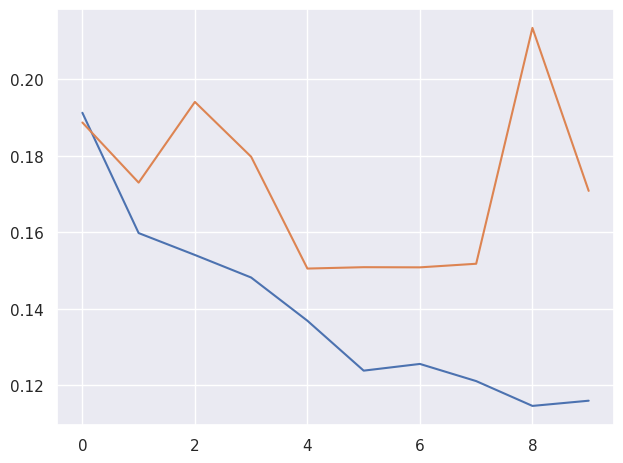

In [74]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

4/4 [==============================] - 0s 3ms/step
[[9.9999994e-01 1.4996254e-09]
 [9.9571168e-01 4.2883628e-03]
 [9.9054331e-01 9.4567705e-03]
 [9.9999994e-01 9.1825711e-09]
 [9.9999839e-01 1.5482619e-06]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


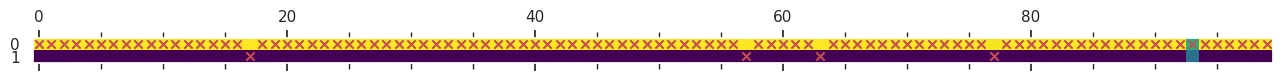

In [75]:
who = np.random.randint(len(y_test),size=100)
predictions=model.predict(X_test[who,:])
plt.matshow(predictions.T, cmap = "viridis")
plt.scatter( np.arange(len(who)), np.argmax(y_test[who], axis=-1), marker="x", color="r")
plt.grid("")

print(predictions[:5])
print(y_test[who][:5])

In [76]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(ohenc.inverse_transform(y_test), ohenc.inverse_transform(y_pred)))

16/16 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       465
        True       0.00      0.00      0.00        21

    accuracy                           0.96       486
   macro avg       0.48      0.50      0.49       486
weighted avg       0.92      0.96      0.94       486



/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/djanloo/.virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

79/79 [==============================] - 0s 4ms/step


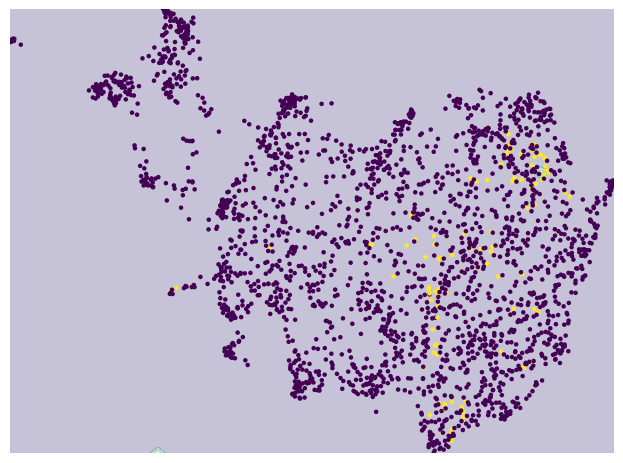

In [77]:
boundary_on_UMAP_proj(X, 
                      y[:,1], 
                      model, 
                      lambda x: x[:, 1])

## GradientBoosting Machine

In [101]:
categ_X_df = df.copy()
for col in df[categorical_attr_list].columns.difference(["emotion"]):
    categ_X_df[f"num_{col}"] = pd.Categorical(df[col]).codes
categ_X_df = categ_X_df.drop(df[categorical_attr_list].columns.difference(["emotion"]))
categ_X_df

KeyError: "['actor', 'emotional_intensity', 'repetition', 'sex', 'statement', 'vocal_channel'] not found in axis"

In [94]:
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

numer_X_df = pd.DataFrame( MinMaxScaler().fit_transform( PCA(n_components=20).fit_transform(df[numerical_attr_list])))
categ_X_df = df[df[categorical_attr_list].columns.difference(["emotion"])]
full_X_df = numer_X_df.join(categ_X_df)
print(full_X_df)

X = full_X_df
y = (df["emotion"] == "angry").values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

alberto = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=3, random_state=0)
alberto.fit(X_train, y_train)
pred = alberto.predict(X_test)
print(classification_report(y_true=y_test, y_pred=pred))

ValueError: columns overlap but no suffix specified: RangeIndex(start=0, stop=1, step=1)

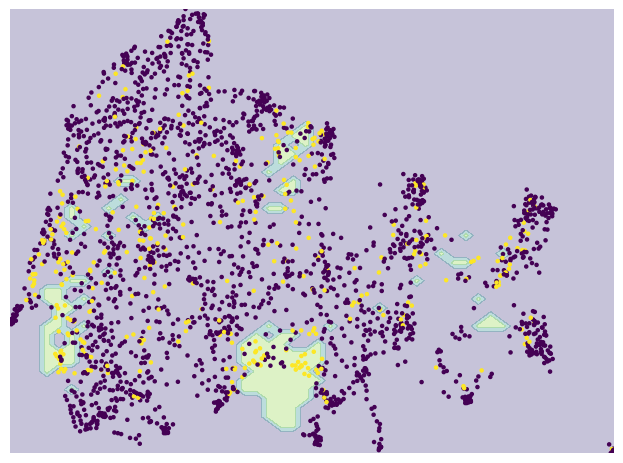

In [ ]:
boundary_on_UMAP_proj(X, y.astype(int), alberto, lambda x: x.astype(int) )